# **Predict Flight Delays**

In [ ]:
%pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 10.9 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=d196df6aa8917ab1c62242092cd685e593873e1427763df9e230dec7954a6b6c
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


## **Import Libraries**

In [ ]:
import numpy as np
import pandas
import time
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from IPython.core.display import display
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType
from pyspark.sql import functions as f
from pyspark.sql import Row
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, NaiveBayes
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import MinMaxScaler,StandardScaler
from pyspark.ml.pipeline import PipelineModel

sns.set()

spark = SparkSession.builder.appName('FinalProject') .config("spark.driver.memory", "50g") .config("spark.executor.memory", "50g") .getOrCreate()
spark

Mounted at /content/drive


## **Read Dataset**

In [ ]:
PATH = '/content/drive/MyDrive/PREDICT/'

In [ ]:
# Read dataset.csv
data = spark.read.csv(PATH+'Dataset/train_final.csv', header=True, inferSchema=True)
data.printSchema()
data.show(20,False)
data.count()

root
 |-- ID: string (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- LABEL: integer (nullable = true)

+------------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+
|ID                      |QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|
+------------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+
|1/1/2023_9E_DLH_MSP_4630|1      |1    |1           |7          |9E               |DLH   |MSP |144.0   |510         |1    |
|1/1/2023_9E_ORF_DTW_4633|1      |1    |1          

6743403

## **Prepare data**

In [ ]:
train, test = data.randomSplit(weights=[0.8,0.2], seed=2024)

In [ ]:
train.printSchema()
train.show()    
train.count()

root
 |-- ID: string (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- LABEL: integer (nullable = true)

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+
|1/1/2023_9E_ABE_A...|      1|    1|           1|          7|               9E|   ABE| ATL|   692.0|         600|    1|
|1/1/2023_9E_ABY_A...|      1|    1|           1|          7|      

5394973

In [ ]:
test.printSchema()
test.show()
test.count()

root
 |-- ID: string (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- LABEL: integer (nullable = true)

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+
|1/1/2023_9E_ABY_A...|      1|    1|           1|          7|               9E|   ABY| ATL|   145.0|         736|    0|
|1/1/2023_9E_AGS_A...|      1|    1|           1|          7|      

1348430

<ipython-input-8-9d3700860107>:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


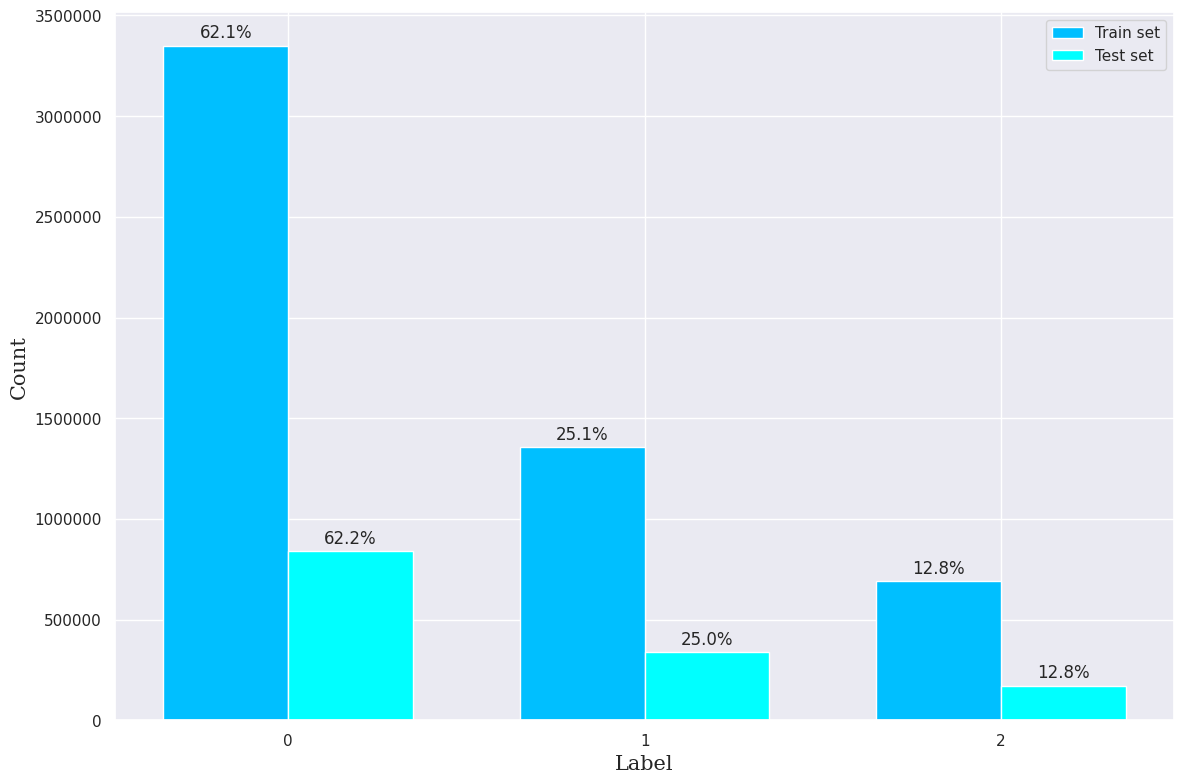

In [ ]:
df_train = train.select('LABEL').toPandas()
df_test = test.select('LABEL').toPandas()

label_train = list(df_train.LABEL.value_counts())
label_test = list(df_test.LABEL.value_counts())

rate_train = [round(x * 100 / sum(label_train), 1) for x in label_train]
rate_test = [round(x * 100 / sum(label_test), 1) for x in label_test]

labels = ['G1', 'G2', 'G3']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize =(12, 8))
rects1 = ax.bar(x - width/2, label_train, width, label='Train set', color ='#00BFFF')
rects2 = ax.bar(x + width/2, label_test, width, label='Test set', color ='#00FFFF')
ax = plt.gca()
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_xticklabels(labels)
ax.legend()

def autolabel_train(rects):
    i = 0
    for rect in rects:
        height = rect.get_height()
        height_2 = str(rate_train[i]) + '%'
        i = i + 1
        ax.annotate('{}'.format(height_2),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
def autolabel_test(rects):
    i = 0
    for rect in rects:
        height = rect.get_height()
        height_2 = str(rate_test[i]) + '%'
        i = i + 1
        ax.annotate('{}'.format(height_2),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel_train(rects1)
autolabel_test(rects2)
# Adding Xticks
plt.xlabel('Label', fontsize = 15, fontfamily='serif')
plt.ylabel('Count', fontsize = 15, fontfamily='serif')
plt.xticks([r for r in range(len(label_train))], ['0', '1', '2'])
fig.tight_layout()
plt.show()

## **Build & Evaluation Model**

### Logistic Regression

#### Training model

In [ ]:
stringIndexer = StringIndexer(inputCols=['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST'],
                              outputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'])

In [ ]:
oneHotEncoder = OneHotEncoder(inputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'],
                              outputCols=['OP_UNIQUE_CARRIERVec', 'ORIGINVec','DESTVec'])

In [ ]:
assembler = VectorAssembler(inputCols=['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIERVec', 'ORIGINVec',
                                       'DESTVec', 'DISTANCE', 'CRS_DEP_TIME'], outputCol='features')

In [ ]:
LR = LogisticRegression(featuresCol='features',labelCol='LABEL')

In [ ]:
pipeline = Pipeline(stages=[stringIndexer,
                            oneHotEncoder,
                            assembler, LR])

In [ ]:
%%time
model_LR = pipeline.fit(train)

CPU times: user 187 ms, sys: 35.4 ms, total: 223 ms
Wall time: 24.5 s


#### Evaluation model

##### Train

In [ ]:
Trained = model_LR.transform(train)
Trained.show(truncate=False)
Trained.count()

+------------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+-----------------------------------------------------------------------------+-------------------------------------------------------------+-------------------------------------------------------------+----------+
|ID                      |QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|ORIGINVec        |DESTVec          |features                                                                     |rawPrediction                                                |probability                                                  |prediction|
+------------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----

5394973

In [ ]:
Trained.select('prediction').groupBy('prediction').count().show()

+----------+-------+
|prediction|  count|
+----------+-------+
|       0.0|4906268|
|       1.0| 443955|
|       2.0|  44750|
+----------+-------+



In [ ]:
predicted_train = Trained.select("prediction", 'LABEL')
predicted_train_score = predicted_train.toPandas()

print(classification_report(predicted_train_score.LABEL,
                            predicted_train_score.prediction,
                            target_names=['0', '1', '2'], digits=4))

              precision    recall  f1-score   support

           0     0.6503    0.9526    0.7729   3349244
           1     0.4556    0.1492    0.2248   1355778
           2     0.3560    0.0231    0.0434    689951

    accuracy                         0.6318   5394973
   macro avg     0.4873    0.3749    0.3470   5394973
weighted avg     0.5637    0.6318    0.5419   5394973



In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_train = evaluator.evaluate(Trained)
f1_mic = f1_score(predicted_train_score['LABEL'],
                  predicted_train_score['prediction'],
                  average = 'micro')
f1_mac = f1_score(predicted_train_score['LABEL'],
                  predicted_train_score['prediction'],
                  average = 'macro')

print('='*15+'Training Data'+'='*15)
print(f'Accuracy: {accuracy_train*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Training Data===============
Accuracy: 63.17972%
F1-Micro: 63.17972%
F1-Macro: 34.70158%


##### Test

In [ ]:
Tested = model_LR.transform(test)
Tested.show()
Tested.count()

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|        ORIGINVec|          DESTVec|            features|       rawPrediction|         probability|prediction|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|1/1/2023_9E_ABY_A...|      1|    1|           1|          7|               9E|   ABY| ATL|   145.0|         736

1348430

In [ ]:
Tested.select('prediction').groupBy('prediction').count().show()

+----------+-------+
|prediction|  count|
+----------+-------+
|       0.0|1226172|
|       1.0| 111138|
|       2.0|  11120|
+----------+-------+



In [ ]:
predicted_test = Tested.select("prediction", 'LABEL')
predicted_test_score = predicted_test.toPandas()

from sklearn.metrics import classification_report
print(classification_report(predicted_test_score.LABEL,
                            predicted_test_score.prediction,
                            target_names=['0', '1', '2'], digits=4))

              precision    recall  f1-score   support

           0     0.6513    0.9526    0.7736    838401
           1     0.4544    0.1495    0.2250    337780
           2     0.3471    0.0224    0.0421    172249

    accuracy                         0.6326   1348430
   macro avg     0.4843    0.3748    0.3469   1348430
weighted avg     0.5631    0.6326    0.5428   1348430



In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_test = evaluator.evaluate(Tested)
f1_mic = f1_score(predicted_test_score['LABEL'],
                  predicted_test_score['prediction'],
                  average = 'micro')
f1_mac = f1_score(predicted_test_score['LABEL'],
                  predicted_test_score['prediction'],
                  average = 'macro')

print('='*15+'Testing Data'+'='*15)
print(f'Accuracy: {accuracy_test*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Testing Data===============
Accuracy: 63.25749%
F1-Micro: 63.25749%
F1-Macro: 34.69080%


#### Save & Load model

In [ ]:
model_LR.write().overwrite().save(PATH+'Model/LR')

In [ ]:
model_LR_load = PipelineModel.load(PATH+'Model/LR')

### Decision Tree

#### Training model

In [ ]:
stringIndexer = StringIndexer(inputCols=['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST'],
                              outputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'])

In [ ]:
oneHotEncoder = OneHotEncoder(inputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'],
                              outputCols=['OP_UNIQUE_CARRIERVec', 'ORIGINVec','DESTVec'])

In [ ]:
assembler = VectorAssembler(inputCols=['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIERVec', 'ORIGINVec',
                                       'DESTVec', 'DISTANCE', 'CRS_DEP_TIME'], outputCol='features')

In [ ]:
DT = DecisionTreeClassifier(maxDepth=16,featuresCol='features',labelCol='LABEL')#

In [ ]:
pipeline = Pipeline(stages=[stringIndexer,
                            oneHotEncoder,
                            assembler, DT])

In [ ]:
%%time
model_DT = pipeline.fit(train)

CPU times: user 2.73 s, sys: 467 ms, total: 3.2 s
Wall time: 5min


#### Evaluation model

##### Train

In [ ]:
Trained = model_DT.transform(train)
Trained.show()
Trained.count()

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|        ORIGINVec|          DESTVec|            features|       rawPrediction|         probability|prediction|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|1/1/2023_9E_ABE_A...|      1|    1|           1|          7|               9E|   ABE| ATL|   692.0|         600

5394973

In [ ]:
Trained.select('prediction').groupBy('prediction').count().show()

+----------+-------+
|prediction|  count|
+----------+-------+
|       0.0|4661834|
|       1.0| 586742|
|       2.0| 146397|
+----------+-------+



In [ ]:
predicted_train = Trained.select("prediction", 'LABEL')
predicted_train_score = predicted_train.toPandas()

print(classification_report(predicted_train_score.LABEL,
                            predicted_train_score.prediction,
                            target_names=['0', '1', '2'], digits=4))

              precision    recall  f1-score   support

           0     0.6759    0.9408    0.7866   3349244
           1     0.5258    0.2275    0.3176   1355778
           2     0.5250    0.1114    0.1838    689951

    accuracy                         0.6555   5394973
   macro avg     0.5755    0.4266    0.4293   5394973
weighted avg     0.6189    0.6555    0.5917   5394973



In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_train = evaluator.evaluate(Trained)
f1_mic = f1_score(predicted_train_score['LABEL'],
                  predicted_train_score['prediction'],
                  average = 'micro')
f1_mac = f1_score(predicted_train_score['LABEL'],
                  predicted_train_score['prediction'],
                  average = 'macro')

print('='*15+'Training Data'+'='*15)
print(f'Accuracy: {accuracy_train*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Training Data===============
Accuracy: 65.54530%
F1-Micro: 65.54530%
F1-Macro: 42.93409%


##### Test

In [ ]:
Tested = model_DT.transform(test)
Tested.show()
Tested.count()

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|        ORIGINVec|          DESTVec|            features|       rawPrediction|         probability|prediction|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|1/1/2023_9E_ABY_A...|      1|    1|           1|          7|               9E|   ABY| ATL|   145.0|         736

1348430

In [ ]:
Tested.select('prediction').groupBy('prediction').count().show()

+----------+-------+
|prediction|  count|
+----------+-------+
|       0.0|1165556|
|       1.0| 146273|
|       2.0|  36601|
+----------+-------+



In [ ]:
predicted_test = Tested.select("prediction", 'LABEL')
predicted_test_score = predicted_test.toPandas()

from sklearn.metrics import classification_report
print(classification_report(predicted_test_score.LABEL,
                            predicted_test_score.prediction,
                            target_names=['0', '1', '2'], digits=4))

              precision    recall  f1-score   support

           0     0.6711    0.9329    0.7806    838401
           1     0.4813    0.2084    0.2909    337780
           2     0.4534    0.0963    0.1589    172249

    accuracy                         0.6446   1348430
   macro avg     0.5353    0.4126    0.4101   1348430
weighted avg     0.5957    0.6446    0.5785   1348430



In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_test = evaluator.evaluate(Tested)
f1_mic = f1_score(predicted_test_score['LABEL'],
                  predicted_test_score['prediction'],
                  average = 'micro')
f1_mac = f1_score(predicted_test_score['LABEL'],
                  predicted_test_score['prediction'],
                  average = 'macro')

print('='*15+'Testing Data'+'='*15)
print(f'Accuracy: {accuracy_test*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Testing Data===============
Accuracy: 64.45696%
F1-Micro: 64.45696%
F1-Macro: 41.01449%


#### Save & Load model

In [ ]:
model_DT.write().overwrite().save(PATH+'Model/DT')

In [ ]:
model_DT_load = PipelineModel.load(PATH+'Model/DT')

### Random Forest

#### Training model

In [ ]:
stringIndexer = StringIndexer(inputCols=['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST'],
                              outputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'])

In [ ]:
oneHotEncoder = OneHotEncoder(inputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'],
                              outputCols=['OP_UNIQUE_CARRIERVec', 'ORIGINVec','DESTVec'])

In [ ]:
assembler = VectorAssembler(inputCols=['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIERVec', 'ORIGINVec',
                                       'DESTVec', 'DISTANCE', 'CRS_DEP_TIME'], outputCol='features')

In [ ]:
RF = RandomForestClassifier(maxDepth=10, numTrees = 3, featuresCol='features', labelCol='LABEL')#

In [ ]:
pipeline = Pipeline(stages=[stringIndexer,
                            oneHotEncoder,
                            assembler, RF])

In [ ]:
%%time
model_RF = pipeline.fit(train)

CPU times: user 338 ms, sys: 51.1 ms, total: 390 ms
Wall time: 37.5 s


#### Evaluation model

##### Train

In [ ]:
Trained = model_RF.transform(train)
Trained.show()
Trained.count()

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|        ORIGINVec|          DESTVec|            features|       rawPrediction|         probability|prediction|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|1/1/2023_9E_ABE_A...|      1|    1|           1|          7|               9E|   ABE| ATL|   692.0|         600

5394973

In [ ]:
Trained.select('prediction').groupBy('prediction').count().show()

+----------+-------+
|prediction|  count|
+----------+-------+
|       0.0|5392943|
|       1.0|   2029|
|       2.0|      1|
+----------+-------+



In [ ]:
predicted_train = Trained.select("prediction", 'LABEL')
predicted_train_score = predicted_train.toPandas()

print(classification_report(predicted_train_score.LABEL,
                            predicted_train_score.prediction,
                            target_names=['0', '1', '2'], digits=4))

              precision    recall  f1-score   support

           0     0.6210    0.9999    0.7661   3349244
           1     0.5323    0.0008    0.0016   1355778
           2     1.0000    0.0000    0.0000    689951

    accuracy                         0.6209   5394973
   macro avg     0.7178    0.3336    0.2559   5394973
weighted avg     0.6472    0.6209    0.4760   5394973



In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_train = evaluator.evaluate(Trained)
f1_mic = f1_score(predicted_train_score['LABEL'],
                  predicted_train_score['prediction'],
                  average = 'micro')
f1_mac = f1_score(predicted_train_score['LABEL'],
                  predicted_train_score['prediction'],
                  average = 'macro')

print('='*15+'Training Data'+'='*15)
print(f'Accuracy: {accuracy_train*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Training Data===============
Accuracy: 62.09460%
F1-Micro: 62.09460%
F1-Macro: 25.59140%


##### Test

In [ ]:
Tested = model_RF.transform(test)
Tested.show()
Tested.count()

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|        ORIGINVec|          DESTVec|            features|       rawPrediction|         probability|prediction|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|1/1/2023_9E_ABY_A...|      1|    1|           1|          7|               9E|   ABY| ATL|   145.0|         736

1348430

In [ ]:
Tested.select('prediction').groupBy('prediction').count().show()

+----------+-------+
|prediction|  count|
+----------+-------+
|       0.0|1347913|
|       1.0|    517|
+----------+-------+



In [ ]:
predicted_test = Tested.select("prediction", 'LABEL')
predicted_test_score = predicted_test.toPandas()

from sklearn.metrics import classification_report
print(classification_report(predicted_test_score.LABEL,
                            predicted_test_score.prediction,
                            target_names=['0', '1', '2'], digits=4))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0     0.6219    0.9999    0.7669    838401
           1     0.4971    0.0008    0.0015    337780
           2     0.0000    0.0000    0.0000    172249

    accuracy                         0.6219   1348430
   macro avg     0.3730    0.3336    0.2561   1348430
weighted avg     0.5112    0.6219    0.4772   1348430



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_test = evaluator.evaluate(Tested)
f1_mic = f1_score(predicted_test_score['LABEL'],
                  predicted_test_score['prediction'],
                  average = 'micro')
f1_mac = f1_score(predicted_test_score['LABEL'],
                  predicted_test_score['prediction'],
                  average = 'macro')

print('='*15+'Testing Data'+'='*15)
print(f'Accuracy: {accuracy_test*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Testing Data===============
Accuracy: 62.18884%
F1-Micro: 62.18884%
F1-Macro: 25.61318%


#### Save & Load model

In [ ]:
model_RF.write().overwrite().save(PATH+'Model/RF')

In [ ]:
model_RF_load = PipelineModel.load(PATH+'Model/RF')

### Naive Bayes

#### Training model

In [ ]:
stringIndexer = StringIndexer(inputCols=['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST'],
                              outputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'])

In [ ]:
oneHotEncoder = OneHotEncoder(inputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'],
                              outputCols=['OP_UNIQUE_CARRIERVec', 'ORIGINVec','DESTVec'])

In [ ]:
assembler = VectorAssembler(inputCols=['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIERVec', 'ORIGINVec',
                                       'DESTVec', 'DISTANCE', 'CRS_DEP_TIME'], outputCol='features')

In [ ]:
NB = NaiveBayes(featuresCol='features',labelCol='LABEL',smoothing=0.0003,modelType="multinomial")#

In [ ]:
pipeline = Pipeline(stages=[stringIndexer,
                            oneHotEncoder,
                            assembler, NB])

In [ ]:
%%time
model_NB = pipeline.fit(train)

CPU times: user 61.6 ms, sys: 17.6 ms, total: 79.1 ms
Wall time: 3.78 s


#### Evaluation model

##### Train

In [ ]:
Trained = model_NB.transform(train)
Trained.show()
Trained.count()

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|        ORIGINVec|          DESTVec|            features|       rawPrediction|         probability|prediction|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|1/1/2023_9E_ABE_A...|      1|    1|           1|          7|               9E|   ABE| ATL|   692.0|         600

5394973

In [ ]:
Trained.select('prediction').groupBy('prediction').count().show()

+----------+-------+
|prediction|  count|
+----------+-------+
|       0.0|2275229|
|       1.0| 287112|
|       2.0|2832632|
+----------+-------+



In [ ]:
predicted_train = Trained.select("prediction", 'LABEL')
predicted_train_score = predicted_train.toPandas()

print(classification_report(predicted_train_score.LABEL,
                            predicted_train_score.prediction,
                            target_names=['0', '1', '2'], digits=4))

              precision    recall  f1-score   support

           0     0.6638    0.4509    0.5370   3349244
           1     0.3600    0.0762    0.1258   1355778
           2     0.1435    0.5890    0.2307    689951

    accuracy                         0.3744   5394973
   macro avg     0.3891    0.3720    0.2979   5394973
weighted avg     0.5209    0.3744    0.3945   5394973



In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_train = evaluator.evaluate(Trained)
f1_mic = f1_score(predicted_train_score['LABEL'],
                  predicted_train_score['prediction'],
                  average = 'micro')
f1_mac = f1_score(predicted_train_score['LABEL'],
                  predicted_train_score['prediction'],
                  average = 'macro')

print('='*15+'Training Data'+'='*15)
print(f'Accuracy: {accuracy_train*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Training Data===============
Accuracy: 37.44182%
F1-Micro: 37.44182%
F1-Macro: 29.78550%


##### Test

In [ ]:
Tested = model_NB.transform(test)
Tested.show()
Tested.count()

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|        ORIGINVec|          DESTVec|            features|       rawPrediction|         probability|prediction|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|1/1/2023_9E_ABY_A...|      1|    1|           1|          7|               9E|   ABY| ATL|   145.0|         736

1348430

In [ ]:
Tested.select('prediction').groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|       0.0|568180|
|       1.0| 71923|
|       2.0|708327|
+----------+------+



In [ ]:
predicted_test = Tested.select("prediction", 'LABEL')
predicted_test_score = predicted_test.toPandas()

from sklearn.metrics import classification_report
print(classification_report(predicted_test_score.LABEL,
                            predicted_test_score.prediction,
                            target_names=['0', '1', '2'], digits=4))

              precision    recall  f1-score   support

           0     0.6640    0.4500    0.5364    838401
           1     0.3576    0.0762    0.1256    337780
           2     0.1436    0.5905    0.2310    172249

    accuracy                         0.3743   1348430
   macro avg     0.3884    0.3722    0.2977   1348430
weighted avg     0.5208    0.3743    0.3945   1348430



In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_test = evaluator.evaluate(Tested)
f1_mic = f1_score(predicted_test_score['LABEL'],
                  predicted_test_score['prediction'],
                  average = 'micro')
f1_mac = f1_score(predicted_test_score['LABEL'],
                  predicted_test_score['prediction'],
                  average = 'macro')

print('='*15+'Testing Data'+'='*15)
print(f'Accuracy: {accuracy_test*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Testing Data===============
Accuracy: 37.42768%
F1-Micro: 37.42768%
F1-Macro: 29.76636%


#### Save & Load model

In [ ]:
model_NB.write().overwrite().save(PATH+'Model/NB')

In [ ]:
model_NB_load = PipelineModel.load(PATH+'Model/NB')